# Student Performance Microbenchmark
Simple statistical queries about students in a Portuguese class.
This file is adapted to use numpy only without Spark.

In [1]:
EXPERIMENT = 'pac-student_performance-sparkless'
OUTPUT_DIR = f'./outputs/{EXPERIMENT}'
GENERATE = True
USE_EVEN_NUMBER_OF_INPUT_ROWS = True
SEED_RANDOM_NUMBER_GENERATOR = True

if GENERATE:
    print("GENERATE = True, so we will generate new samples.")
else:
    print("GENERATE = False, so we will load saved output from files rather than recomputing.")

import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)



GENERATE = True, so we will generate new samples.


### Running PAC

In [2]:
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
if SEED_RANDOM_NUMBER_GENERATOR:
    np.random.seed(0)

import pandas as pd
from pandas import DataFrame
import concurrent.futures
import pyarrow as pa
import pyarrow.parquet as pq
import pickle
from numpy.random import laplace
from functools import reduce
import operator

In [3]:
### Mayuri's conversion functions between DP epsilon and PAC MI using posterior advantage for equivalence
def calc_posterior(mi, prior=0.5, prec = 100000):
    test_vals = [x / prec for x in range(1, prec)]
    max_t = None
    for t in test_vals:
        if t*np.log(t/prior)+(1-t)*np.log((1-t)/(1-prior)) <= mi:
            if  max_t is None or t > max_t:
                max_t = t
    return max_t

def dp_epsilon_to_posterior_success(epsilon):
    return 1 - 1./(1+np.exp(epsilon))

def dp_ps_to_epsilon(ps):
    return np.log(ps / (1-ps))

# example usage:
# dp_ps_to_epsilon(calc_posterior(1/256.))

In [4]:
### Data Setup
por_df = pq.read_table(f"./data/student_performance/student-por.parquet").to_pandas()
# drop last row
if USE_EVEN_NUMBER_OF_INPUT_ROWS:
    if por_df.shape[0] % 2 != 0:
        print(f"Input data has odd number of rows ({por_df.shape[0]}), dropping last row to make it even.")
        por_df = por_df.iloc[:-1]
por_df.shape

Input data has odd number of rows (649), dropping last row to make it even.


(648, 33)

In [5]:
por_df['absences'].count()

648

In [6]:
true_result = por_df['absences'].agg(['count', 'sum', 'mean']).to_numpy()
true_result

array([ 648.        , 2371.        ,    3.65895062])

In [7]:
### Query Setup
SAMPLES = 1024
assert SAMPLES % 2 == 0, "We need an even number of samples for paired sampling."
number_of_pairs = SAMPLES // 2

true_result = por_df['absences'].agg(['count', 'sum', 'mean']).to_numpy() # Save the true result of the query for later
number_of_contributing_rows = por_df['absences'].count()

def poisson_paired_sample(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    """
    This will select a subset of indices, where each index is selected with probability 0.5.
    The first result is the dataframe composed of the selected rows.
    The second result is the complement / the dataframe composed of the rows that were not selected.
    """
    indices = []
    for i in df.index:
        if np.random.choice([0, 1], p=[0.5, 0.5]):
            indices.append(i)
    not_indices = list(set(df.index) - set(indices))
    selected: DataFrame = df.iloc[indices]
    not_selected: DataFrame = df.iloc[not_indices]
    return (selected, not_selected)

def run_query(i: int) -> List[np.ndarray]:
    # i is not used for anything, just to satisfy the map function.
    # Returns two results each invocation as a result of paired sampling.
    results = []
    for temp_df in poisson_paired_sample(por_df):
        out_df = temp_df['absences'].agg(['count', 'mean'])  # run the query
        #out_df['count'] *= 2  # correct query result for the 50% subsampling
        #out_df['sum'] *= 2  # correct query result for the 50% subsampling
        results.append(out_df.to_numpy())
    return results

def generate_samples(laplace_lambda: float = 1.0, alpha: int = 10) -> List[np.ndarray]:
    # thresholding happens here for PAC -- if there are less than alpha samples
    # (with some Laplacian noise), then we don't subsample and return None.
    laplace_noise: float = np.random.laplace(scale=laplace_lambda)
    if number_of_contributing_rows + laplace_noise < alpha:  # if we don't get enough results from the query
        print("There are not enough rows contributing to the result for PAC to be meaningful.")
        return []
    
    out_np: List[np.ndarray] = []
    for i in range(number_of_pairs):
        out_np.append(run_query(i))
    out_np = reduce(operator.iconcat, out_np, [])
    # https://stackoverflow.com/a/45323085

    #with concurrent.futures.ThreadPoolExecutor() as executor:
    #    out_np: List[np.ndarray] = list(executor.map(run_query, range(number_of_pairs)))
    #    out_np = reduce(operator.iconcat, out_np, [])
    #    # https://stackoverflow.com/a/45323085

    return out_np

In [8]:
#s = generate_samples()
#s

#pd.DataFrame(s, columns=['count', 'mean']).hist("count")
#pd.DataFrame(s, columns=['count', 'mean']).hist("sum")
#pd.DataFrame(s, columns=['count', 'mean']).hist("mean")

In [9]:
# compute variance of pd.DataFrame(s, columns=['count', 'mean'])['sum']
#np.var(pd.DataFrame(s, columns=['count', 'mean'])['count'])

In [10]:
### Compute PAC Noise
def updateDataFrame(vec: np.ndarray, df: DataFrame) -> DataFrame:
    """
    Update a DataFrame with a noisy output vector.
    """
    noisy_output_df = df.copy()
    noisy_output_df.loc[0] = vec
    return noisy_output_df

saved_pac_variables = []
# (out_np[0], fin_var, sqrt_total_var, pac_noise, pac_noises_to_add, pac_release)


def get_pac_noise_variance(out_np: List[np.ndarray],
                           max_mi: float = 1./4) -> np.ndarray:
    dimensions: int = len(out_np[0])

    out_np_2darr = [np.atleast_2d(o) for o in out_np] # make sure all the DF -> np.ndarray conversions result in 2d arrays

    est_y: np.ndarray = np.stack(out_np_2darr, axis=-1).reshape(dimensions, SAMPLES)

    # get the variance in each basis direction
    fin_var: np.ndarray = np.var(est_y, axis=1)  # shape (dimensions,)
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(fin_var))

    pac_noise: np.ndarray = (1./(2*max_mi)) * sqrt_total_var * np.sqrt(fin_var)  # variance of the PAC noise
    return pac_noise

def do_pac_and_release(out_np: List[np.ndarray],
                       max_mi: float = 1./4,
                       variance: np.ndarray = None,
                       chosen_index: int = None) -> np.ndarray:
    
    if variance is not None:
        pac_noise: np.ndarray = variance
    else:
        pac_noise = get_pac_noise_variance(out_np, max_mi)

    pac_noises_to_add: np.ndarray = np.random.normal(loc=0, scale=pac_noise)
    # Add noise element-wise to the outputs
    if chosen_index is None:  # allow for overriding the chosen index to specify which sample to use for the release
        chosen_index = np.random.choice(np.arange(SAMPLES))
    pac_release = out_np[chosen_index] + pac_noises_to_add

    #saved_pac_variables.append((max_mi, out_np[chosen_index], fin_var, sqrt_total_var, pac_noise, pac_noises_to_add, pac_release))
    
    return pac_release

# Update the DataFrame with the noisy output
# noisy_output_df = updateDataFrame(pac_release, out[0])

To replicate the experiment that runs for epsilon=0.01, 0.1, 1, 10
we use mi=1, 1/4, 1/16, 1/64, 1/256 in the hopes of encompassing a similar range.

In [11]:
MI_OPTIONS = [16., 4., 2., 1., 1/4, 1/16, 1/32, 1/64]
EXPERIMENTS = 1000

if GENERATE:
    # df = pd.DataFrame([], columns=['mi', 'count', 'sum', 'mean', 'var'])
    experiment_results = []
    experiment_results_unnoised = []

    out_np = generate_samples() # generate samples (results of running the query)
    for mi in MI_OPTIONS:
        variance = get_pac_noise_variance(out_np, mi) # estimate the stability of the query
        #out_np = generate_samples() # generate samples (results of running the query)
        print(f"MI: {mi}, assessed variance: {variance}")
        for e in range(EXPERIMENTS):
            chosen_index = np.random.choice(np.arange(len(out_np))) # chose a random sample to add noise to for this release
            chosen_sample = out_np[chosen_index]
            chosen_sample[0] = chosen_sample[0] * 2
            experiment_results_unnoised.append(chosen_sample)
            noisy_output = do_pac_and_release(out_np, mi, variance, chosen_index)
            # manually correct count = count * 2
            noisy_output[0] = noisy_output[0] * 2
            # manually add sum as count * mean
            noisy_output = [noisy_output[0], noisy_output[0] * noisy_output[1], noisy_output[1]]
            experiment_results.append([mi, *noisy_output])
        with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
            pickle.dump(experiment_results, f)
    
    df = pd.DataFrame(experiment_results, columns=['mi', 'count', 'sum', 'mean'])
    
    # Save the new data to outputs/...
    df.to_parquet(f'{OUTPUT_DIR}/pac_results.parquet')
    # with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
    #     pickle.dump(experiment_results, f)
else:
    df = pq.read_table(f"{OUTPUT_DIR}/pac_results.parquet").to_pandas()

    # with open('{OUTPUT_DIR}/experiment_results.pkl', 'rb') as f:
    #     experiment_results = pickle.load(f)

df.head()

MI: 16.0, assessed variance: [4.68598502 0.07108031]
MI: 4.0, assessed variance: [1.69784917e+05 2.68592360e+01]
MI: 2.0, assessed variance: [9.53098410e+06 2.84577203e+02]
MI: 1.0, assessed variance: [9.24087096e+08 3.96275418e+03]
MI: 0.25, assessed variance: [1.68566621e+10 3.38497894e+04]
MI: 0.0625, assessed variance: [3.80376459e+11 3.21593112e+05]
MI: 0.03125, assessed variance: [1.16796228e+14 7.96946486e+06]
MI: 0.015625, assessed variance: [2.52987173e+14 1.65874261e+07]


,mi,count,sum,mean
0,16.0,1245.308162,4664.616264,3.745753
1,16.0,1321.175427,5098.593259,3.859134
2,16.0,1304.555412,4660.480476,3.572466
3,16.0,1285.438531,4895.690567,3.808576
4,16.0,1215.813906,4503.362862,3.703990


In [12]:
### DEBUG: Save the variables from computing the PAC noises for later reverse engineering
if GENERATE:
    saved_pac_variables_df = pd.DataFrame(saved_pac_variables, columns=['mi', 'out_np_0', 'fin_var', 'sqrt_total_var', 'pac_noise', 'pac_noises_to_add', 'pac_release'])
    saved_pac_variables_df.to_parquet(f'{OUTPUT_DIR}/saved_pac_variables.parquet')
else:
    saved_pac_variables_df = pq.read_table(f"{OUTPUT_DIR}/saved_pac_variables.parquet").to_pandas()
saved_pac_variables_df.head()

,mi,out_np_0,fin_var,sqrt_total_var,pac_noise,pac_noises_to_add,pac_release


### Computing PAC Errors

In [13]:
# functions to calculate errors
def absolute_scaled_error(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return np.abs(est - actual)
def relative_error_percent(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return (np.abs(est - actual) / actual) * 100

In [14]:
OUTPUT_COLS = ['count', 'sum', 'mean']
ERROR_COLS = [*[f'absolute error {i}' for i in OUTPUT_COLS], *[f'relative error {i}' for i in OUTPUT_COLS]]

In [15]:
# compute errors for PAC (or import from saved file)
if GENERATE:
    errors_list = []
    for i, row in df.iterrows():
        mi = row['mi']
        r = row[OUTPUT_COLS].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    pac_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    pac_errors_df.to_parquet(f"{OUTPUT_DIR}/pac_errors.parquet")  # overwrite saved
else:
    pac_errors_df = pq.read_table(f"{OUTPUT_DIR}/pac_errors.parquet").to_pandas()
pac_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,relative error count,relative error sum,relative error mean
0,16.000000,5.973082e+02,2.293616e+03,8.680196e-02,9.217719e+01,9.673624e+01,2.372319e+00
1,16.000000,6.731754e+02,2.727593e+03,2.001836e-01,1.038851e+02,1.150398e+02,5.471065e+00
2,16.000000,6.565554e+02,2.289480e+03,8.648414e-02,1.013203e+02,9.656181e+01,2.363632e+00
3,16.000000,6.374385e+02,2.524691e+03,1.496256e-01,9.837014e+01,1.064821e+02,4.089303e+00
4,16.000000,5.678139e+02,2.132363e+03,4.503964e-02,8.762560e+01,8.993517e+01,1.230944e+00
...,...,...,...,...,...,...,...
7995,0.015625,2.728116e+14,6.714322e+21,2.461157e+07,4.210055e+13,2.831852e+20,6.726401e+08
7996,0.015625,1.296610e+15,3.863118e+22,2.979398e+07,2.000942e+14,1.629320e+21,8.142767e+08
7997,0.015625,1.975058e+14,5.933434e+20,3.004178e+06,3.047929e+13,2.502503e+19,8.210491e+07
7998,0.015625,6.189620e+14,2.293033e+21,3.704638e+06,9.551883e+13,9.671162e+19,1.012487e+08


In [16]:
# if GENERATE:
#     mean_df = df.groupby('mi').mean()[['count', 'sum', 'mean', 'var']]
#     std_df = df.groupby('mi').std()[['count', 'sum', 'mean', 'var']].abs()
#     mean_df, std_df

#     # save mean_df, std_df to parquet
#     mean_df.to_parquet('{OUTPUT_DIR}/pac-mean_df_student-por.parquet')
#     std_df.to_parquet('{OUTPUT_DIR}/pac-std_df_student-por.parquet')

### Computing DP Errors

### Analysis of PAC vs DP
- import the DP data
- create a dataframe (`all_df`) containing the query outputs
    - in this df, each output is the {mean, variance} aggregation over the 500 experiments, grouped by the type of privacy mechanism used (pac or dp) and privacy factor (mi or epsilon)
- create a dataframe in the same pattern containing the computed error for each privitized output

In [17]:
# Import Chai's saved data from running PipelineDP and use it to compare.
dp_results_df = pq.read_table(f"outputs/dp_results.parquet").to_pandas()

# compute sum from count and mean
dp_results_df['sum'] = dp_results_df['count'] * dp_results_df['mean']
dp_results_df = dp_results_df[['mi', 'count', 'sum', 'mean']]

dp_results_df

,mi,count,sum,mean
0,0.003906,660.050940,2598.420761,3.936697
1,0.003906,650.576555,2116.923464,3.253919
2,0.003906,657.433996,2228.459453,3.389632
3,0.003906,644.239500,2875.046901,4.462699
4,0.003906,634.495431,2520.045497,3.971732
...,...,...,...,...
895,16.000000,648.910033,2374.250822,3.658829
896,16.000000,649.067287,2372.422164,3.655125
897,16.000000,648.942620,2367.126350,3.647667
898,16.000000,649.044352,2379.478704,3.666127


In [18]:
# compute errors for DP (or import from saved file)
GENERATE_DP = True
if GENERATE_DP:
    errors_list = []
    for i, row in dp_results_df.iterrows():
        mi = row['mi']
        r = row[OUTPUT_COLS].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    dp_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    dp_errors_df.to_parquet(f"outputs/dp_errors.parquet")  # overwrite saved
else:
    dp_errors_df = pq.read_table(f"outputs/dp_errors.parquet").to_pandas()
dp_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,relative error count,relative error sum,relative error mean
0,0.003906,12.050940,227.420761,0.277747,1.859713,9.591766,7.590884
1,0.003906,2.576555,254.076536,0.405032,0.397616,10.716007,11.069609
2,0.003906,9.433996,142.540547,0.269318,1.455864,6.011832,7.360537
3,0.003906,3.760500,504.046901,0.803748,0.580324,21.258832,21.966633
4,0.003906,13.504569,149.045497,0.312781,2.084038,6.286187,8.548377
...,...,...,...,...,...,...,...
895,16.000000,0.910033,3.250822,0.000122,0.140437,0.137108,0.003325
896,16.000000,1.067287,1.422164,0.003825,0.164705,0.059982,0.104551
897,16.000000,0.942620,3.873650,0.011284,0.145466,0.163376,0.308394
898,16.000000,1.044352,8.478704,0.007176,0.161165,0.357600,0.196119


In [19]:
### Make one merged DF to compare results
all_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_results_df.assign(type='dp').rename(columns={'eps': 'factor'}),
    dp_results_df.assign(type='dp').rename(columns={'mi': 'factor'}),
    df.assign(type='pac').rename(columns={'mi': 'factor'})
])
all_df = all_df.groupby(['type', 'factor']).agg(['mean', 'var'])
all_df.columns = [' '.join(col).strip() for col in all_df.columns.values]  # Flatten the columns
#all_df.to_parquet(f"{OUTPUT_DIR}/all_results.parquet")  # Save the merged results
all_df

count mean     count var      sum mean       sum var  \
type factor                                                              
dp   0.003906   6.485928e+02  6.045818e+01  2.398074e+03  8.634635e+04   
     0.007812   6.488976e+02  2.688194e+01  2.389478e+03  3.990028e+04   
     0.015625   6.492117e+02  1.530226e+01  2.393518e+03  1.589616e+04   
     0.062500   6.492498e+02  5.904308e+00  2.378578e+03  3.755536e+03   
     0.250000   6.490493e+02  7.038266e-01  2.372399e+03  8.077147e+02   
     1.000000   6.489982e+02  1.466184e-02  2.375337e+03  1.758985e+01   
     2.000000   6.490076e+02  2.109847e-02  2.375222e+03  2.088131e+01   
     4.000000   6.489910e+02  1.273822e-02  2.375039e+03  1.595267e+01   
     16.000000  6.490112e+02  1.554098e-02  2.375140e+03  1.788450e+01   
pac  0.015625   3.155741e+13  2.756208e+29  1.164396e+20  7.570636e+43   
     0.031250   4.021739e+12  5.167248e+28  1.156247e+20  3.253017e+42   
     0.062500   6.898361e+09  5.792881e+23  6.059515e+15  5.745248e+34   
     0.250000   7.441782e+08  1.157424e+21 -2.028077e+13  1.290280e+30   
     1.000000   4.290301e+07  3.213696e+18  5.832976e+11  4.802868e+25   
     2.000000   2.860012e+05  3.592251e+14  1.074392e+08  3.560515e+19   
     4.000000  -2.712614e+03  1.122219e+11 -3.740095e+05  6.825449e+13   
     16.000000  2.228250e+03  6.000501e+06  8.167513e+03  8.291609e+07   

                    mean mean      mean var  
type factor                                  
dp   0.003906        3.697400  2.021884e-01  
     0.007812        3.683002  9.789932e-02  
     0.015625        3.686918  3.805641e-02  
     0.062500        3.663558  8.562503e-03  
     0.250000        3.655199  1.959264e-03  
     1.000000        3.660006  4.172429e-05  
     2.000000        3.659775  4.753992e-05  
     4.000000        3.659587  3.792342e-05  
     16.000000       3.659629  4.106861e-05  
pac  0.015625  -568909.682511  2.708689e+14  
     0.031250   -90806.491401  6.379090e+13  
     0.062500     5547.542634  1.035034e+11  
     0.250000     1223.029019  1.144514e+09  
     1.000000       34.200378  1.525306e+07  
     2.000000       17.581898  7.785904e+04  
     4.000000        3.751053  6.761482e+02  
     16.000000       3.660283  3.764761e-02

In [20]:
### Make another merged df for the errors
errors_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_errors_df.assign(type='dp').rename(columns={'eps': 'factor'}), 
    dp_errors_df.assign(type='dp').rename(columns={'mi': 'factor'}),
    pac_errors_df.assign(type='pac').rename(columns={'mi': 'factor'})
])
errors_df = errors_df.groupby(['type', 'factor']).agg(['mean', 'var'])
# drop absolute * mean and relative * var columns from level 1
errors_df = errors_df.drop(columns=[('absolute error count', 'mean'), ('absolute error mean', 'mean'), ('relative error count', 'var'), ('relative error mean', 'var')])
errors_df.columns = [' '.join(col).strip() for col in errors_df.columns.values]  # flatten the columns

#errors_df.to_parquet(f"{OUTPUT_DIR}/all_errors.parquet")
errors_df

absolute error count var  absolute error sum mean  \
type factor                                                         
dp   0.003906               2.460359e+01             2.104454e+02   
     0.007812               1.155811e+01             1.323586e+02   
     0.015625               7.320963e+00             8.965661e+01   
     0.062500               3.452589e+00             4.422851e+01   
     0.250000               5.042486e-01             1.983535e+01   
     1.000000               1.466184e-02             5.012504e+00   
     2.000000               2.109847e-02             4.818485e+00   
     4.000000               1.273822e-02             4.740504e+00   
     16.000000              1.554098e-02             5.085376e+00   
pac  0.015625               9.756812e+28             5.387073e+21   
     0.031250               1.969982e+28             1.150274e+21   
     0.062500               2.047356e+23             1.518875e+17   
     0.250000               4.110568e+20             7.327031e+14   
     1.000000               1.135765e+18             4.366275e+12   
     2.000000               1.416982e+14             3.490580e+09   
     4.000000               3.756559e+10             5.568274e+06   
     16.000000              6.000501e+06             5.796513e+03   

                absolute error sum var  absolute error mean var  \
type factor                                                       
dp   0.003906             4.235214e+04             9.977196e-02   
     0.007812             2.254940e+04             5.695895e-02   
     0.015625             8.288853e+03             1.948102e-02   
     0.062500             1.837621e+03             4.262447e-03   
     0.250000             4.122751e+02             9.666393e-04   
     1.000000             1.121277e+01             2.085207e-05   
     2.000000             1.543418e+01             2.462932e-05   
     4.000000             9.729479e+00             1.564373e-05   
     16.000000            9.074661e+00             1.855848e-05   
pac  0.015625             4.667032e+43             1.049403e+14   
     0.031250             1.941946e+42             2.323629e+13   
     0.062500             3.439633e+34             3.798980e+10   
     0.250000             7.533006e+29             4.181367e+08   
     1.000000             2.928582e+25             5.813954e+06   
     2.000000             2.342036e+19             2.983206e+04   
     4.000000             3.735958e+13             2.435382e+02   
     16.000000            8.291609e+07             1.300573e-02   

                relative error count mean  relative error sum mean  \
type factor                                                          
dp   0.003906                9.239628e-01             8.875807e+00   
     0.007812                6.168263e-01             5.582394e+00   
     0.015625                4.723744e-01             3.781384e+00   
     0.062500                3.082240e-01             1.865395e+00   
     0.250000                1.758570e-01             8.365817e-01   
     1.000000                1.540406e-01             2.114089e-01   
     2.000000                1.554916e-01             2.032259e-01   
     4.000000                1.529329e-01             1.999369e-01   
     16.000000               1.560455e-01             2.144823e-01   
pac  0.015625                6.526710e+13             2.272068e+20   
     0.031250                2.758717e+13             4.851428e+19   
     0.062500                9.440428e+10             6.406052e+15   
     0.250000                4.215461e+09             3.090270e+13   
     1.000000                2.224415e+08             1.841533e+11   
     2.000000                2.275336e+06             1.472198e+08   
     4.000000                4.214770e+04             2.348492e+05   
     16.000000               2.438657e+02             2.444755e+02   

                relative error sum var  relative error mean mean  
type factor                     

In [21]:
#abs_error = errors_df.groupby('mi').mean()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

#std_abs_error = errors_df.groupby('mi').std()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#sample_mean_rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

# save std_abs_error, sample_mean_rel_error to parquet
# std_abs_error.to_parquet('outputs/pac-std_abs_error_student-por.parquet')
# sample_mean_rel_error.to_parquet('outputs/pac-sample_mean_rel_error_student-por.parquet')

### Plotting Results

We are reproducing Table 14 from this paper: http://arxiv.org/abs/2109.10789

> TABLE 14: Experiments of the queries count, sum, mean, and var on the attribute Absences of the Portuguese education dataset containing 649 individuals (500 experiments per ε).

In [22]:
### Imports for matplotlib
import matplotlib as mpl
#import seaborn as sns
import matplotlib.pyplot as plt
#sns.reset_orig()

# Michael's matplotlib defaults
# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

In [23]:
import matplotlib.colors as mcolors

PAC_COLOR = 'tab:blue'
DP_COLOR = 'tab:red'

# Function to lighten a color by blending with white
def lighten_color(color, amount=0.3):
    rgba = mcolors.to_rgba(color)
    return tuple(np.clip(np.array(rgba[:3]) + amount, 0, 1)) + (rgba[3],)

# Create lighter colors
PAC_LIGHT = lighten_color(PAC_COLOR, 0.3)
DP_LIGHT = lighten_color(DP_COLOR, 0.3)

# create legend, use color squares
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
pac_dp_legend_handles = [
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP')
]

Reproduction of Table 14 (PAC)

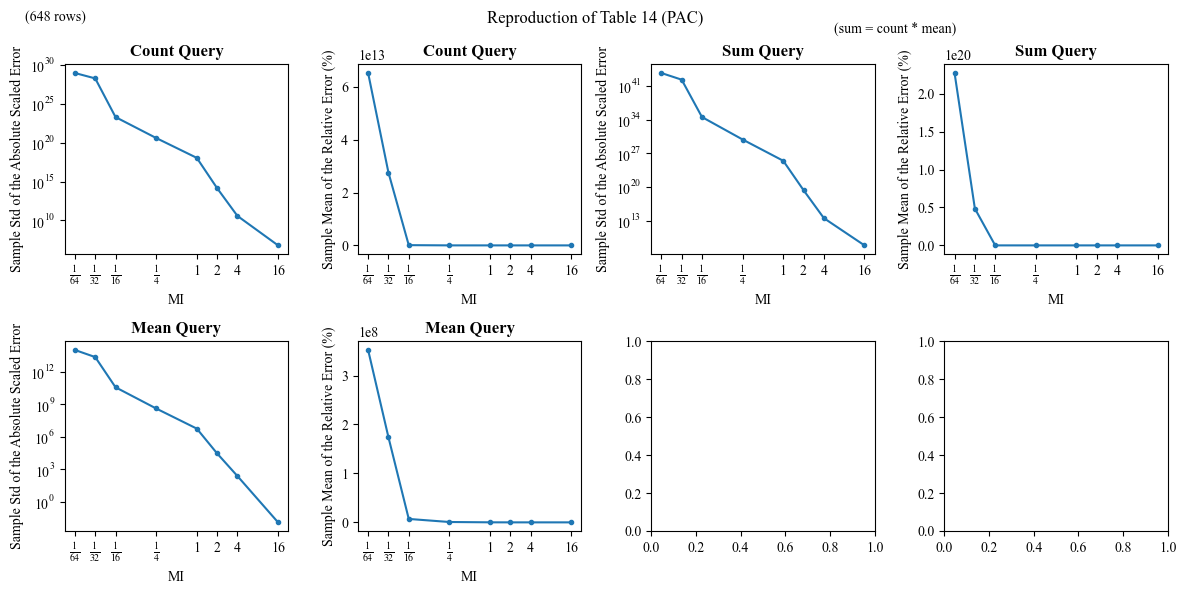

In [24]:
### Reproduction of Table 14 (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'pac'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
             #label=query, marker='.')

    ax1.set_yscale('log')

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.95, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({por_df.shape[0]} rows)', ha='center', va='center')
fig.suptitle("Reproduction of Table 14 (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac.jpg", bbox_inches='tight')
plt.show()

Reproduction of Table 14 (DP)

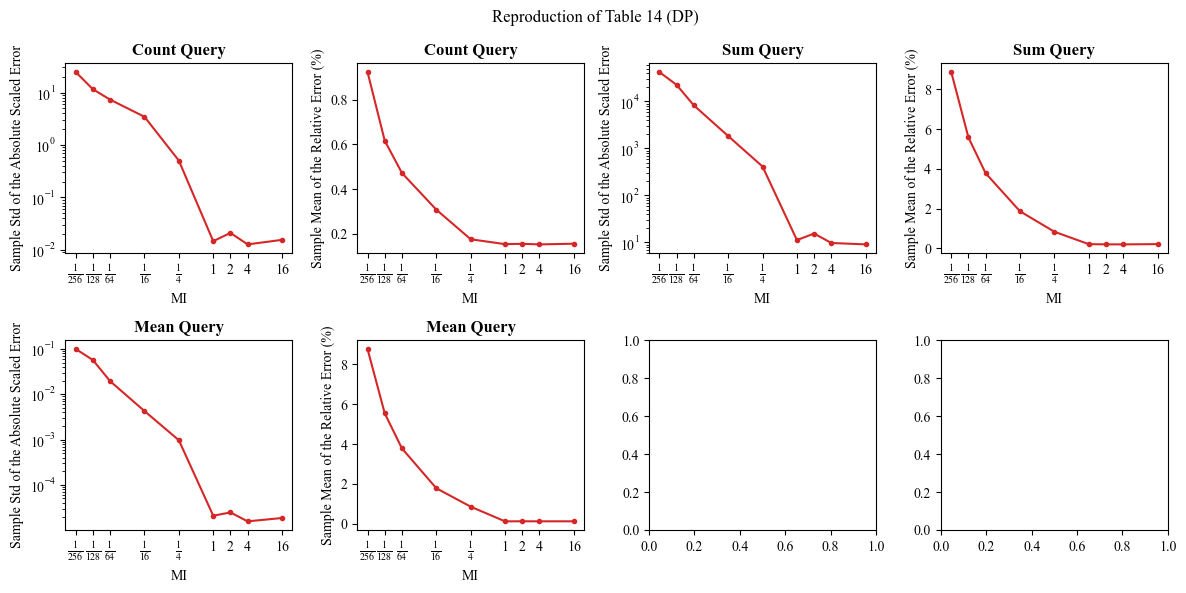

In [25]:
### Reproduction of Table 14 (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/256, 1/128, 1/64, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'dp'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
             #label=query, marker='.')
    
    ax1.set_yscale('log')

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

fig.suptitle("Reproduction of Table 14 (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_dp.jpg", bbox_inches='tight')
plt.show()

Both on the same axes, aligned

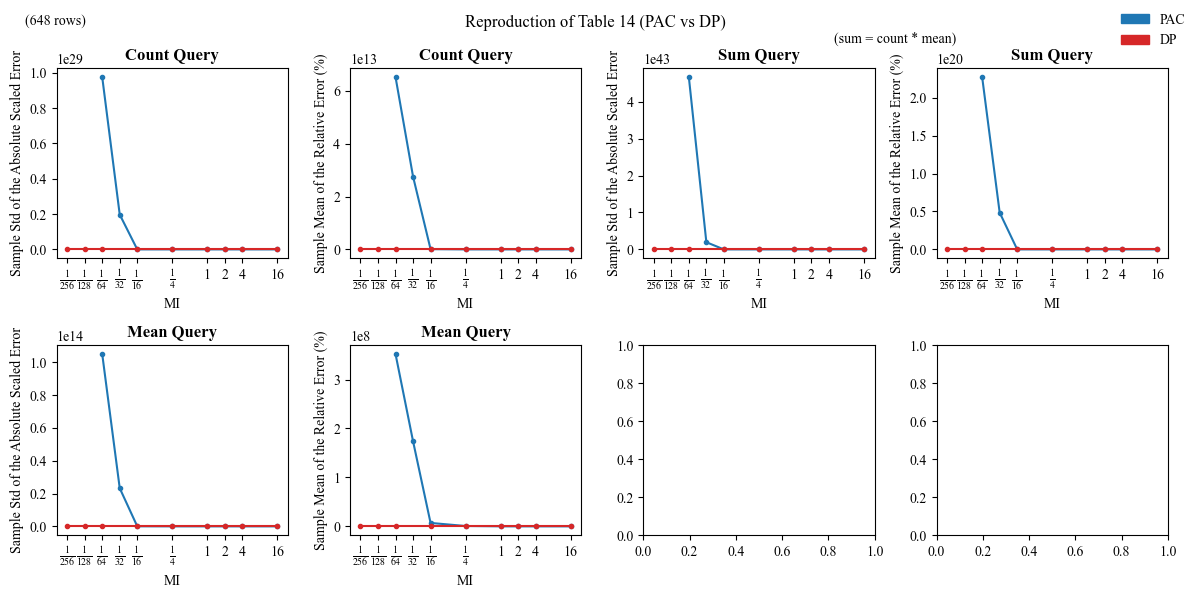

In [26]:
### Both on the same axes, aligned
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/256, 1/128, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    d = errors_df.loc['pac'].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'absolute error {query} var']
    #print(d)
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')
    ax1.set_xlabel('MI')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc['pac'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    
    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')
    ax2.set_xlabel('MI')

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False)

fig.text(0.05, 0.97, f'({por_df.shape[0]} rows)', ha='center', va='center')
fig.suptitle("Reproduction of Table 14 (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac_vs_dp.jpg", bbox_inches='tight')
plt.show()

In [27]:
pac_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,relative error count,relative error sum,relative error mean
0,16.000000,5.973082e+02,2.293616e+03,8.680196e-02,9.217719e+01,9.673624e+01,2.372319e+00
1,16.000000,6.731754e+02,2.727593e+03,2.001836e-01,1.038851e+02,1.150398e+02,5.471065e+00
2,16.000000,6.565554e+02,2.289480e+03,8.648414e-02,1.013203e+02,9.656181e+01,2.363632e+00
3,16.000000,6.374385e+02,2.524691e+03,1.496256e-01,9.837014e+01,1.064821e+02,4.089303e+00
4,16.000000,5.678139e+02,2.132363e+03,4.503964e-02,8.762560e+01,8.993517e+01,1.230944e+00
...,...,...,...,...,...,...,...
7995,0.015625,2.728116e+14,6.714322e+21,2.461157e+07,4.210055e+13,2.831852e+20,6.726401e+08
7996,0.015625,1.296610e+15,3.863118e+22,2.979398e+07,2.000942e+14,1.629320e+21,8.142767e+08
7997,0.015625,1.975058e+14,5.933434e+20,3.004178e+06,3.047929e+13,2.502503e+19,8.210491e+07
7998,0.015625,6.189620e+14,2.293033e+21,3.704638e+06,9.551883e+13,9.671162e+19,1.012487e+08


In [28]:
dp_errors_df

,mi,absolute error count,absolute error sum,absolute error mean,relative error count,relative error sum,relative error mean
0,0.003906,12.050940,227.420761,0.277747,1.859713,9.591766,7.590884
1,0.003906,2.576555,254.076536,0.405032,0.397616,10.716007,11.069609
2,0.003906,9.433996,142.540547,0.269318,1.455864,6.011832,7.360537
3,0.003906,3.760500,504.046901,0.803748,0.580324,21.258832,21.966633
4,0.003906,13.504569,149.045497,0.312781,2.084038,6.286187,8.548377
...,...,...,...,...,...,...,...
895,16.000000,0.910033,3.250822,0.000122,0.140437,0.137108,0.003325
896,16.000000,1.067287,1.422164,0.003825,0.164705,0.059982,0.104551
897,16.000000,0.942620,3.873650,0.011284,0.145466,0.163376,0.308394
898,16.000000,1.044352,8.478704,0.007176,0.161165,0.357600,0.196119


# Additonal Extra Plotting

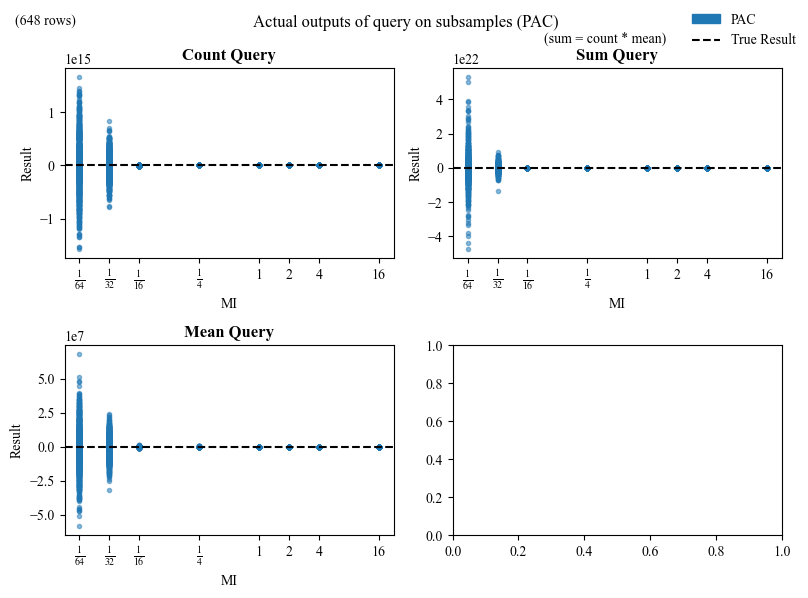

In [29]:
### Plotting the actual experiment outputs used (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'pac'
    ax.scatter(df['mi'], df[query], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
    
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    #for mi in MI_OPTIONS:
        #d = df.iloc[:, [0, i]].where(df['mi'] == mi).dropna()
        #ax.scatter(d.iloc[:, 0], d.iloc[:, 1], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
        #ax.boxplot(d.iloc[:, 1], positions=[mi], widths=0.1, showfliers=False)
    
    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({por_df.shape[0]} rows)', ha='center', va='center')
fig.suptitle("Actual outputs of query on subsamples (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_pac.jpg", bbox_inches='tight')
plt.show()

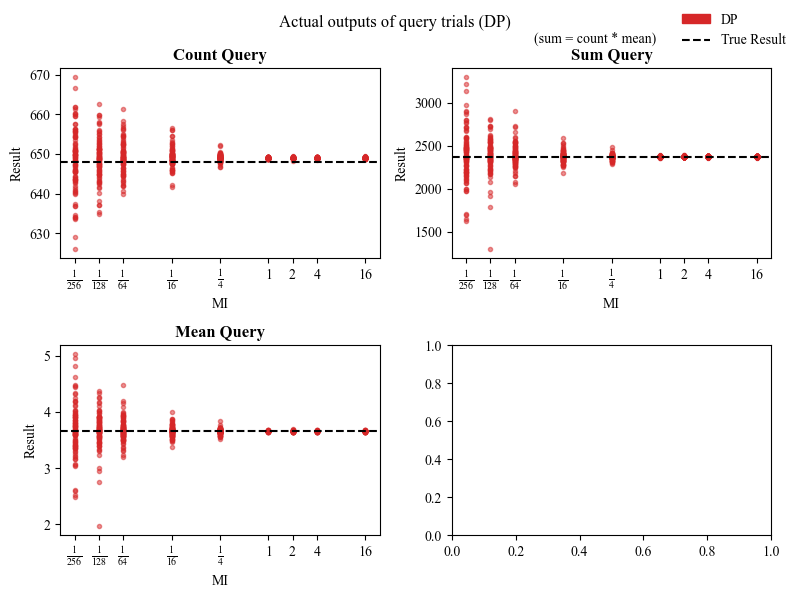

In [30]:
### Plotting the actual experiment outputs used (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/256, 1/128, 1/64, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'dp'

    ax.scatter(dp_results_df['mi'], dp_results_df[query], label=query, marker='.', alpha=0.5, color=DP_COLOR)
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Actual outputs of query trials (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp.jpg", bbox_inches='tight')
plt.show()

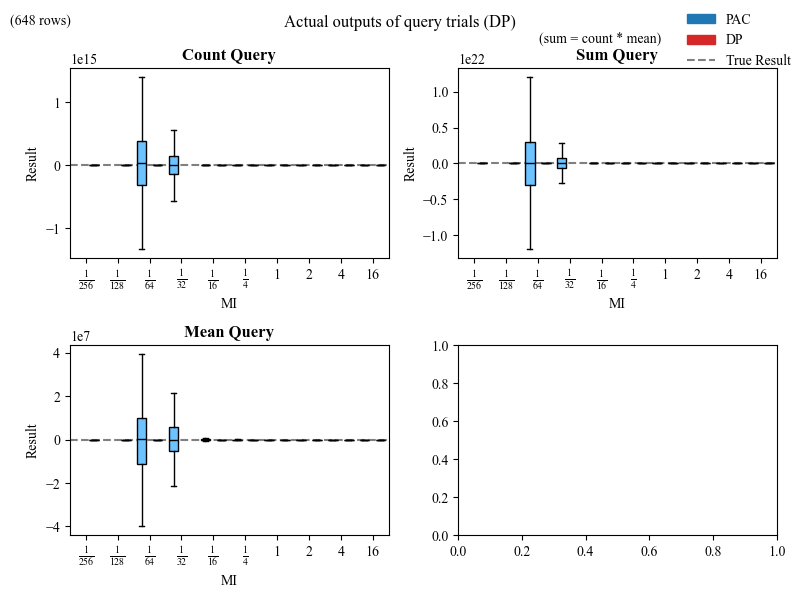

In [31]:
### Both, but with side by side fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/256, 1/128, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    ax.linewidth = 0.25

    # correct answer
    ax.axhline(y=true_result[i], color='gray', linestyle='--', label='True Result')

    for mi in MI_OPTIONS: # categorical variable
        position = MI_OPTIONS.index(mi) * 2

        TYPE = 'pac'

        pac_style = {
            'boxprops': dict(facecolor=PAC_LIGHT),
            'medianprops': dict(color='black')
        }
        
        # mi = mi and query is correct
        d = df[df['mi'] == mi][['mi', query]].iloc[:, 1].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **pac_style)

        position += 1
        TYPE = 'dp'

        dp_style = {
            'boxprops': dict(facecolor=DP_LIGHT),
            'medianprops': dict(color='black')
        }

        # mi = mi and query is correct
        d = dp_results_df[dp_results_df['mi'] == mi][['mi', query]].iloc[:, 1].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **dp_style)
    
    
    
    # override xticks, one for each pair of boxplots
    # the x axis is actually artificial here to plot both PAC and DP side by side
    xticks = [0.5+2*i for i in range(len(MI_OPTIONS))]
    ax.set_xticks(xticks)

    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in MI_OPTIONS]
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='gray', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({por_df.shape[0]} rows)', ha='center', va='center')
fig.suptitle("Actual outputs of query trials (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp_vs_pac.jpg", bbox_inches='tight')
plt.show()


In [32]:
df.groupby('mi').var()

,count,sum,mean
mi,,,
0.015625,2.756208e+29,7.570636e+43,2.708689e+14
0.031250,5.167248e+28,3.253017e+42,6.379090e+13
0.062500,5.792881e+23,5.745248e+34,1.035034e+11
0.250000,1.157424e+21,1.290280e+30,1.144514e+09
1.000000,3.213696e+18,4.802868e+25,1.525306e+07
2.000000,3.592251e+14,3.560515e+19,7.785904e+04
4.000000,1.122219e+11,6.825449e+13,6.761482e+02
16.000000,6.000501e+06,8.291609e+07,3.764761e-02


In [33]:
saved_pac_variables_df
# out_np_0 is the selected sample to which noise is added, [count, mean]
# fin_var is the variance in each basis direction [count, mean]
# sqrt_total_var is the square root of the sum of the variances used in calculating pac_noise
# pac_noises_to_add is the noise actually added to each basis direction (result of laplace(scale=pac_noise))
# pac_release is the final result after adding noise

,mi,out_np_0,fin_var,sqrt_total_var,pac_noise,pac_noises_to_add,pac_release


In [34]:
print("Variance/Stability of Queries [Count, Mean]")
saved_pac_variables_df.groupby('mi').agg({'fin_var': 'mean'})

Variance/Stability of Queries [Count, Mean]


,fin_var
mi,


In [35]:
print("Variance of noise added to [Count, Mean] (scale param passed to Laplace noise function)")
saved_pac_variables_df.groupby('mi').agg({'pac_noise': 'mean'})

Variance of noise added to [Count, Mean] (scale param passed to Laplace noise function)


,pac_noise
mi,


Comparison of how much noise is added to the data, by looking at the variance of the distributions from which noise is sampled.

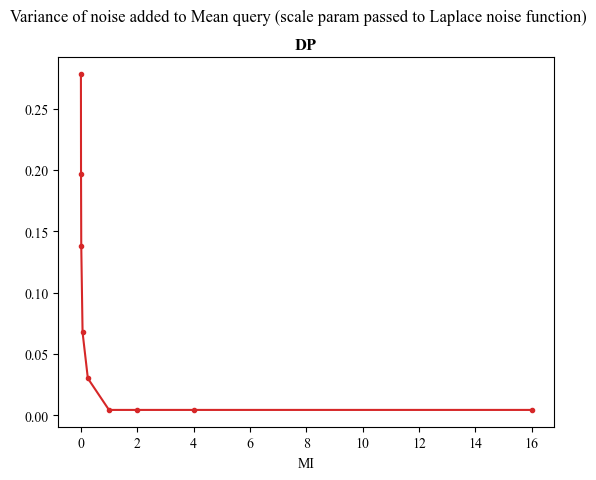

In [36]:
dp_var_noise = {  # from pipelinedp repo, dp_basic_mean_variances.csv
    0.00390625: 0.2784089313555703,
    0.0078125: 0.19648087910574175,
    0.015625: 0.13837628104247293,
    0.0625: 0.06750340282072995,
    0.25: 0.03001721300521553,
    1.0: 0.004282722801885366,
    2.0: 0.004282722801885366,
    4.0: 0.004282722801885366,
    16.0: 0.004282722801885366
}
plt.plot(dp_var_noise.keys(), dp_var_noise.values(), marker='.', label='DP', color=DP_COLOR)
plt.xlabel('MI')
plt.suptitle('Variance of noise added to Mean query (scale param passed to Laplace noise function)')
plt.title('DP')
plt.savefig(f"{OUTPUT_DIR}/var_of_noise_added_to_mean_dp.jpg", bbox_inches='tight')
plt.show()

{0.00390625: 18421.704514386878, 0.0078125: 9210.852257193439, 0.015625: 4605.4261285967195, 0.03125: 2302.7130642983598, 0.0625: 1151.3565321491799, 0.25: 287.83913303729497, 1.0: 71.95978325932374, 2.0: 35.97989162966187, 4.0: 17.989945814830936, 16.0: 4.497486453707734}


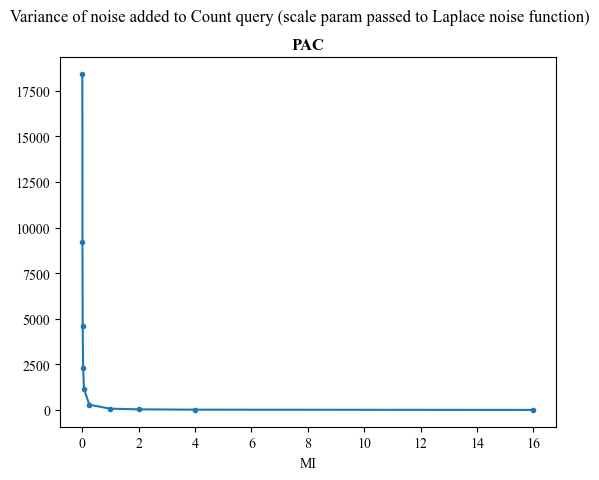

In [37]:
# Let's compute the same for PAC: what is the variance of the distribution from which noise is sampled to add to PAC?
s = generate_samples()
mean_index = ['count', 'mean'].index('count')  # uses the list so that find and replace can update the index used
mi_var_noise = {}
for mi in MI_OPTIONS:
    pac_noise = get_pac_noise_variance(s, mi)
    # we are specifically interested in the mean query
    mi_var_noise[mi] = pac_noise[mean_index]
print(mi_var_noise)
plt.plot(mi_var_noise.keys(), mi_var_noise.values(), marker='.', label='PAC', color=PAC_COLOR)
plt.xlabel('MI')
plt.suptitle('Variance of noise added to Count query (scale param passed to Laplace noise function)')
plt.title('PAC')
plt.savefig(f"{OUTPUT_DIR}/var_of_noise_added_to_count_pac.jpg", bbox_inches='tight')
plt.show()

In [38]:
# How much of PAC error is due to sampling?
s = generate_samples()
sample_errors = []
true_result_temp = por_df['absences'].agg(['count', 'mean']).to_numpy()
for i in range(50):
    sample = s[np.random.choice(np.arange(len(s)))]
    sample_error = relative_error_percent(sample, true_result_temp)
    sample_errors.append({
        'count': sample_error[0],
        'mean': sample_error[1]
    })
sample_errors_df = pd.DataFrame(sample_errors)
#sample_errors_df

In [39]:
sample_errors_df.mean()


count    50.123457
mean      3.842117
dtype: float64

In [40]:
# What percentage of the error is due to sampling?
unnoised_df = pd.DataFrame(experiment_results_unnoised, columns=['count', 'mean'])
unnoised_df_error = (unnoised_df.apply(lambda x: relative_error_percent(x, true_result_temp), axis=1)
                     .rename({'count': 'count query sampling error', 'mean': 'mean query sampling error'}, axis=1))
unnoised_df_error.head()

,count query sampling error,mean query sampling error
0,12304.938272,7.667221
1,3188.888889,6.038050
2,12620.987654,1.882739
3,12700.000000,2.235344
4,48255.555556,0.032252


In [41]:
# Compute total error percentage for comparison
noised_df = df[['mi', 'count', 'mean']]
noised_df_error = (noised_df.apply(lambda x: relative_error_percent(x[1:], true_result_temp), axis=1)
                   .rename({'count': 'count query total error', 'mean': 'mean query total error'}, axis=1))
# readd mi column
noised_df_error = pd.concat([noised_df['mi'], noised_df_error], axis=1)
noised_df_error.head()

,mi,count query total error,mean query total error
0,16.0,92.177186,2.372319
1,16.0,103.885097,5.471065
2,16.0,101.320280,2.363632
3,16.0,98.370144,4.089303
4,16.0,87.625603,1.230944


In [42]:
# Noise-added error = total error - sampling error
noised_df_error = noised_df_error.join(unnoised_df_error)
noised_df_error['count query noise error'] = noised_df_error['count query total error'] - noised_df_error['count query sampling error']
noised_df_error['mean query noise error'] = noised_df_error['mean query total error'] - noised_df_error['mean query sampling error']
noised_df_error.head()

,mi,count query total error,mean query total error,count query sampling error,mean query sampling error,count query noise error,mean query noise error
0,16.0,92.177186,2.372319,12304.938272,7.667221,-12212.761086,-5.294902
1,16.0,103.885097,5.471065,3188.888889,6.038050,-3085.003792,-0.566985
2,16.0,101.320280,2.363632,12620.987654,1.882739,-12519.667375,0.480893
3,16.0,98.370144,4.089303,12700.000000,2.235344,-12601.629856,1.853959
4,16.0,87.625603,1.230944,48255.555556,0.032252,-48167.929953,1.198692


ValueError: When stacked is True, each column must be either all positive or all negative. Column 'count query noise error' contains both positive and negative values

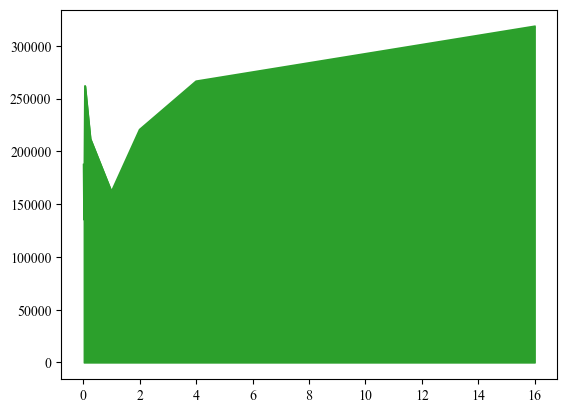

In [44]:
# Plot a stacked area chart showing where the error comes from
d = noised_df_error.groupby('mi').mean()
d[['count query sampling error', 'count query noise error']].plot.area(stacked=True, color=['tab:green', 'tab:orange'])
plt.xlabel('MI')
plt.ylabel('Mean Error (% of true result)')
plt.suptitle('Count Query Error Breakdown')
plt.savefig(f"{OUTPUT_DIR}/count_query_error_breakdown.jpg", bbox_inches='tight')
plt.show()

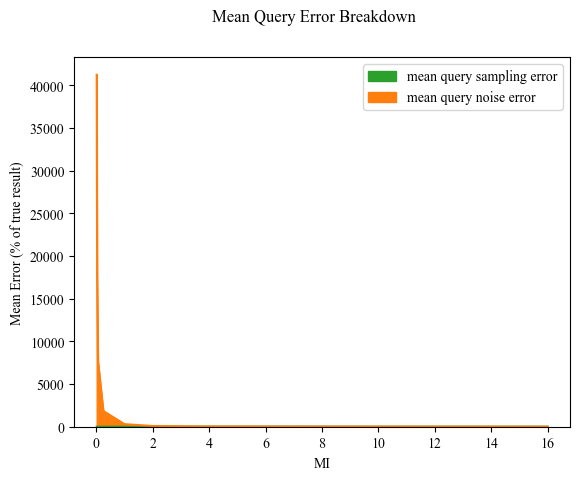

In [44]:
# Plot a stacked area chart showing where the error comes from
d = noised_df_error.groupby('mi').mean()
d[['mean query sampling error', 'mean query noise error']].plot.area(stacked=True, color=['tab:green', 'tab:orange'])
plt.xlabel('MI')
plt.ylabel('Mean Error (% of true result)')
plt.suptitle('Mean Query Error Breakdown')
plt.savefig(f"{OUTPUT_DIR}/mean_query_error_breakdown.jpg", bbox_inches='tight')
plt.show()

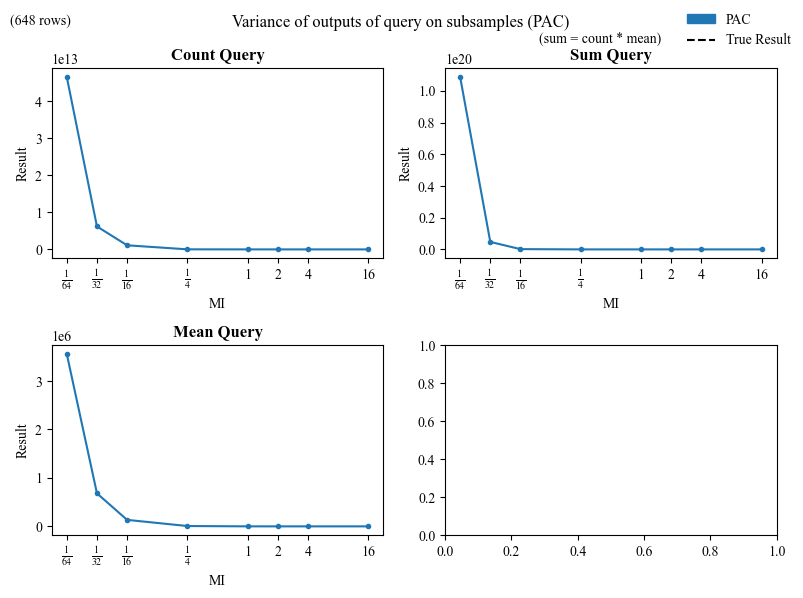

In [ ]:
### Variance plot for PAC
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'pac'
    ax.plot(df.groupby('mi').var().index, df.groupby('mi').var()[query], label=query, marker='.', color=PAC_COLOR)
    
    #ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    #for mi in MI_OPTIONS:
        #d = df.iloc[:, [0, i]].where(df['mi'] == mi).dropna()
        #ax.scatter(d.iloc[:, 0], d.iloc[:, 1], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
        #ax.boxplot(d.iloc[:, 1], positions=[mi], widths=0.1, showfliers=False)
    
    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.text(0.05, 0.97, f'({por_df.shape[0]} rows)', ha='center', va='center')
fig.suptitle("Variance of outputs of query on subsamples (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/var_of_actual_outputs_pac.jpg", bbox_inches='tight')
plt.show()

In [43]:
noised_df_error.groupby('mi').mean()

,count query total error,mean query total error,count query sampling error,mean query sampling error,count query noise error,mean query noise error
mi,,,,,,
0.015625,6.526710e+13,3.522171e+08,187290.098148,4.118967,6.526710e+13,3.522171e+08
0.031250,2.758717e+13,1.739765e+08,135253.754321,4.093446,2.758717e+13,1.739765e+08
0.062500,9.440428e+10,6.993486e+06,261829.526543,4.159084,9.440402e+10,6.993482e+06
0.250000,4.215461e+09,7.369735e+05,211801.635185,4.022718,4.215250e+09,7.369695e+05
1.000000,2.224415e+08,8.392922e+04,161537.991358,4.055709,2.222799e+08,8.392517e+04
2.000000,2.275336e+06,5.998524e+03,220465.372840,4.182288,2.054871e+06,5.994342e+03
4.000000,4.214770e+04,5.681705e+02,266252.150000,4.078770,-2.241044e+05,5.640918e+02
16.000000,2.438657e+02,4.288237e+00,318279.067593,4.003951,-3.180352e+05,2.842866e-01
